In [90]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

import re
#für interactive violinplots (alternative zu seaborn)
import plotly.express as px #conda install plotly
# ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed
    # Method 1: pip install ipykernel
    # Method 2: pip install --upgrade nbformat
        # Method 2 worked for me

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

import mysql.connector #pip install mysql-connector-python

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx #conda install contextily // Didnt work i used 'pip install contextily' instead

# Table of contents

1. [Introduction](#introduction)
2. [Import and preprocessing](#import)
3. [Explorative Data Analysis](#eda)
4. [Geolocation Analysis](#loc)


## Introduction <a name="introduction"></a>
This ipynb file does this and that.

## Import and preprocessing <a name="import"></a>

In [91]:


# Replace these with your connection parameters
config = {
    'host': '127.0.0.1',
    'port':3306,
    'user': 'root',
    'password': 'GabaKDube731',
    'database': 'mlp'
}

# Connect to the MySQL Database
try:
    conn = mysql.connector.connect(**config)
    if conn.is_connected():
        print('Successfully connected to the database')
except mysql.connector.Error as e:
    print('Error:', e)

Successfully connected to the database


In [92]:
# function to read and create a DataFrame
def read_table_to_dataframe(connection, table_name):
    # example usage: df_temp = read_table_to_dataframe(conn, 'dta')
    query = f"SELECT * FROM {table_name}"
    try:
        return pd.read_sql(query, connection)
    except Error as e:
        print(f"The error '{e}' occurred")
        return None
    
df = read_table_to_dataframe(conn, 'dta')

C:\Users\gigim\AppData\Local\Temp\ipykernel_13456\1421185529.py:6: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [93]:
df.to_clipboard()

In [94]:
# Filter out None values from 'rooms' attribute
descriptions = [ 'modern', 'erstvermietung', 'zentral', 'see', 'neu', 'stöckig', 'traum', 'bijou', 'neubau', 'balkon', 'charmant', 'erstbezug']

# Create new attributes for each unique value
for item in descriptions:
    df[item] = df['description'].apply(lambda x: 1 if item in (x or '').lower() else 0)

#df = df.drop(columns=['description'])
# test this to add 'keine_description' if nothing is found
# Add 'keine_description' if no descriptions are found
df['keine_description'] = df[descriptions].sum(axis=1).apply(lambda x: 1 if x == 0 else 0)

# Append new Value to list for Violinplots
descriptions.append('keine_description')

In [95]:
# Filter out None values from 'rooms' attribute
filtered_rooms = [room for room in df['rooms'] if room is not None]

# Extract unique values
unique_rooms = list(set(filtered_rooms))

# Sort unique values
unique_rooms.sort()

# Create new attributes for each unique value
for room_type in unique_rooms:
    df[room_type] = df['rooms'].apply(lambda x: 1 if x == room_type else 0)

# Remove the word 'Zimmer' from the 'rooms' column and convert to numeric
    # Value will be usefull for EDA
df['rooms'] = df['rooms'].str.replace(' Zimmer', '').astype(float)

# Filter out rows where the sum of these specific columns is zero (might have to be moved up)
df = df[df[unique_rooms].sum(axis=1) > 0]


In [96]:
# one Hot encode wbauj
# Filter out None values from 'rooms' attribute
wbauj_list = [wbauj for wbauj in df['wbauj'] if wbauj is not None]

# Extract unique values
wbauj_list = list(set(wbauj_list))
wbauj_list

# Create new attributes for each unique value
for item in wbauj_list:
    df[item] = df['wbauj'].apply(lambda x: 1 if x == item else 0)


# Convert columns as string
df.columns = ['y' + str(col) if isinstance(col, int) else col for col in df.columns]

## Explorative Data Analysis <a name="eda"></a>

In [101]:
# Generate descriptive statistics
display(df[['price', 'address', 'rooms', 'size', 'distance_hospital', 'lr_day', 'lr_night', 'distance_ov', 'wbauj']].describe())

price       rooms  distance_hospital      lr_day    lr_night  \
count    757.000000  757.000000         757.000000  757.000000  757.000000   
mean    3185.027741    2.729855           1.151133   47.236856   39.237120   
std     1430.368345    1.241375           0.816590    9.039382    9.476521   
min      375.000000    1.000000           0.026021    9.300000    0.000000   
25%     2200.000000    2.000000           0.566880   40.500000   32.300000   
50%     2890.000000    2.500000           0.953037   46.300000   38.100000   
75%     3800.000000    3.500000           1.510547   54.000000   45.300000   
max    12653.000000    7.500000           3.806936   70.200000   61.600000   

       distance_ov        wbauj  
count   757.000000   757.000000  
mean      0.140562  1667.871863  
std       0.070928   749.385629  
min       0.016292     0.000000  
25%       0.091067  1999.000000  
50%       0.131931  1999.000000  
75%       0.179911  1999.000000  
max       0.530692  2024.000000

In [102]:
columns = ['modern', 'erstvermietung', 'zentral', 'see', 'neu', 'stöckig', 'traum', 'bijou', 'neubau', 'balkon', 'charmant', 'erstbezug']

# Create a summary table for the counts of 0s and 1s
summary_table = pd.DataFrame()

# Iterate over each specified column in the list
for column in columns:
    counts = df[column].value_counts()
    summary_table[column] = [counts.get(0, 0), counts.get(1, 0)]

# Rename the index for clarity
summary_table.index = ['Count of 0', 'Count of 1']


summary_table

modern  erstvermietung  zentral  see  neu  stöckig  traum  bijou  \
Count of 0     671             716      703  710  701      755    731    746   
Count of 1      86              41       54   47   56        2     26     11   

            neubau  balkon  charmant  erstbezug  
Count of 0     739     739       739        749  
Count of 1      18      18        18          8

In [103]:
columns = ['1 Zimmer', '1.5 Zimmer', '2 Zimmer', '2.5 Zimmer', '3 Zimmer', '3.5 Zimmer', '4 Zimmer', '4.5 Zimmer', '5 Zimmer', '5.5 Zimmer', '6 Zimmer', '6.5 Zimmer', '7 Zimmer', '7.5 Zimmer']

# Create a summary table for the counts of 0s and 1s
summary_table = pd.DataFrame()

# Iterate over each specified column in the list
for column in columns:
    counts = df[column].value_counts()
    summary_table[column] = [counts.get(0, 0), counts.get(1, 0)]

# Rename the index for clarity
summary_table.index = ['Count of 0', 'Count of 1']


summary_table

1 Zimmer  1.5 Zimmer  2 Zimmer  2.5 Zimmer  3 Zimmer  3.5 Zimmer  \
Count of 0       625         705       680         606       687         612   
Count of 1       132          52        77         151        70         145   

            4 Zimmer  4.5 Zimmer  5 Zimmer  5.5 Zimmer  6 Zimmer  6.5 Zimmer  \
Count of 0       728         686       752         742       752         755   
Count of 1        29          71         5          15         5           2   

            7 Zimmer  7.5 Zimmer  
Count of 0       755         756  
Count of 1         2           1

In [104]:
# Violin plot of price by rooms and description

# Melt the DataFrame to long format for Plotly
melted_df = df.melt(id_vars=['price', 'rooms'], value_vars=descriptions, var_name='description', value_name='presence')

# Filter to only include rows where the description is present
filtered_df = melted_df[melted_df['presence'] == 1]

# Create the violin plot using Plotly
fig = px.violin(filtered_df, x='rooms', y='price', color='description', box=True, points='all', hover_data=['description'])
fig.update_layout(title='Violin Plot of Price by Rooms and Description', xaxis_title='Rooms', yaxis_title='Price')
fig.show()

In [105]:
# Violinplot of price by rooms and build year

# List of build years to be considered (assuming unique values from 'wbauj')
wbauj_list = list(set(df['wbauj']))

# Create new binary columns for each build year
for year in wbauj_list:
    df['y' + str(year)] = df['wbauj'].apply(lambda x: 1 if x == year else 0)

# Update the wbauj_list to match the new column names
wbauj_list_str = ['y' + str(year) for year in wbauj_list]

# Melt the DataFrame to long format for Plotly
melted_df = df.melt(id_vars=['price', 'rooms'], value_vars=wbauj_list_str, var_name='Build year', value_name='presence')

# Filter to only include rows where the build year is present
filtered_df = melted_df[melted_df['presence'] == 1]

# Create the violin plot using Plotly
fig = px.violin(filtered_df, x='rooms', y='price', color='Build year', box=True, points='all', hover_data=['Build year'])
fig.update_layout(title='Violin Plot of Price by Rooms and Build Year', xaxis_title='Rooms', yaxis_title='Price')
fig.show()

In [106]:
#Box and Violin Plot of Sound Levels by Time of Day

# Melt the DataFrame to long format
melted_df = df.melt(value_vars=['lr_day', 'lr_night'], var_name='Time of Day', value_name='Sound Level')

# Create the violin plot using Plotly
fig = px.violin(melted_df, x='Time of Day', y='Sound Level', box=True, points='all')
fig.update_layout(title='Box and Violin Plot of Sound Levels by Time of Day', xaxis_title='Time of Day', yaxis_title='Sound Level')
fig.show()

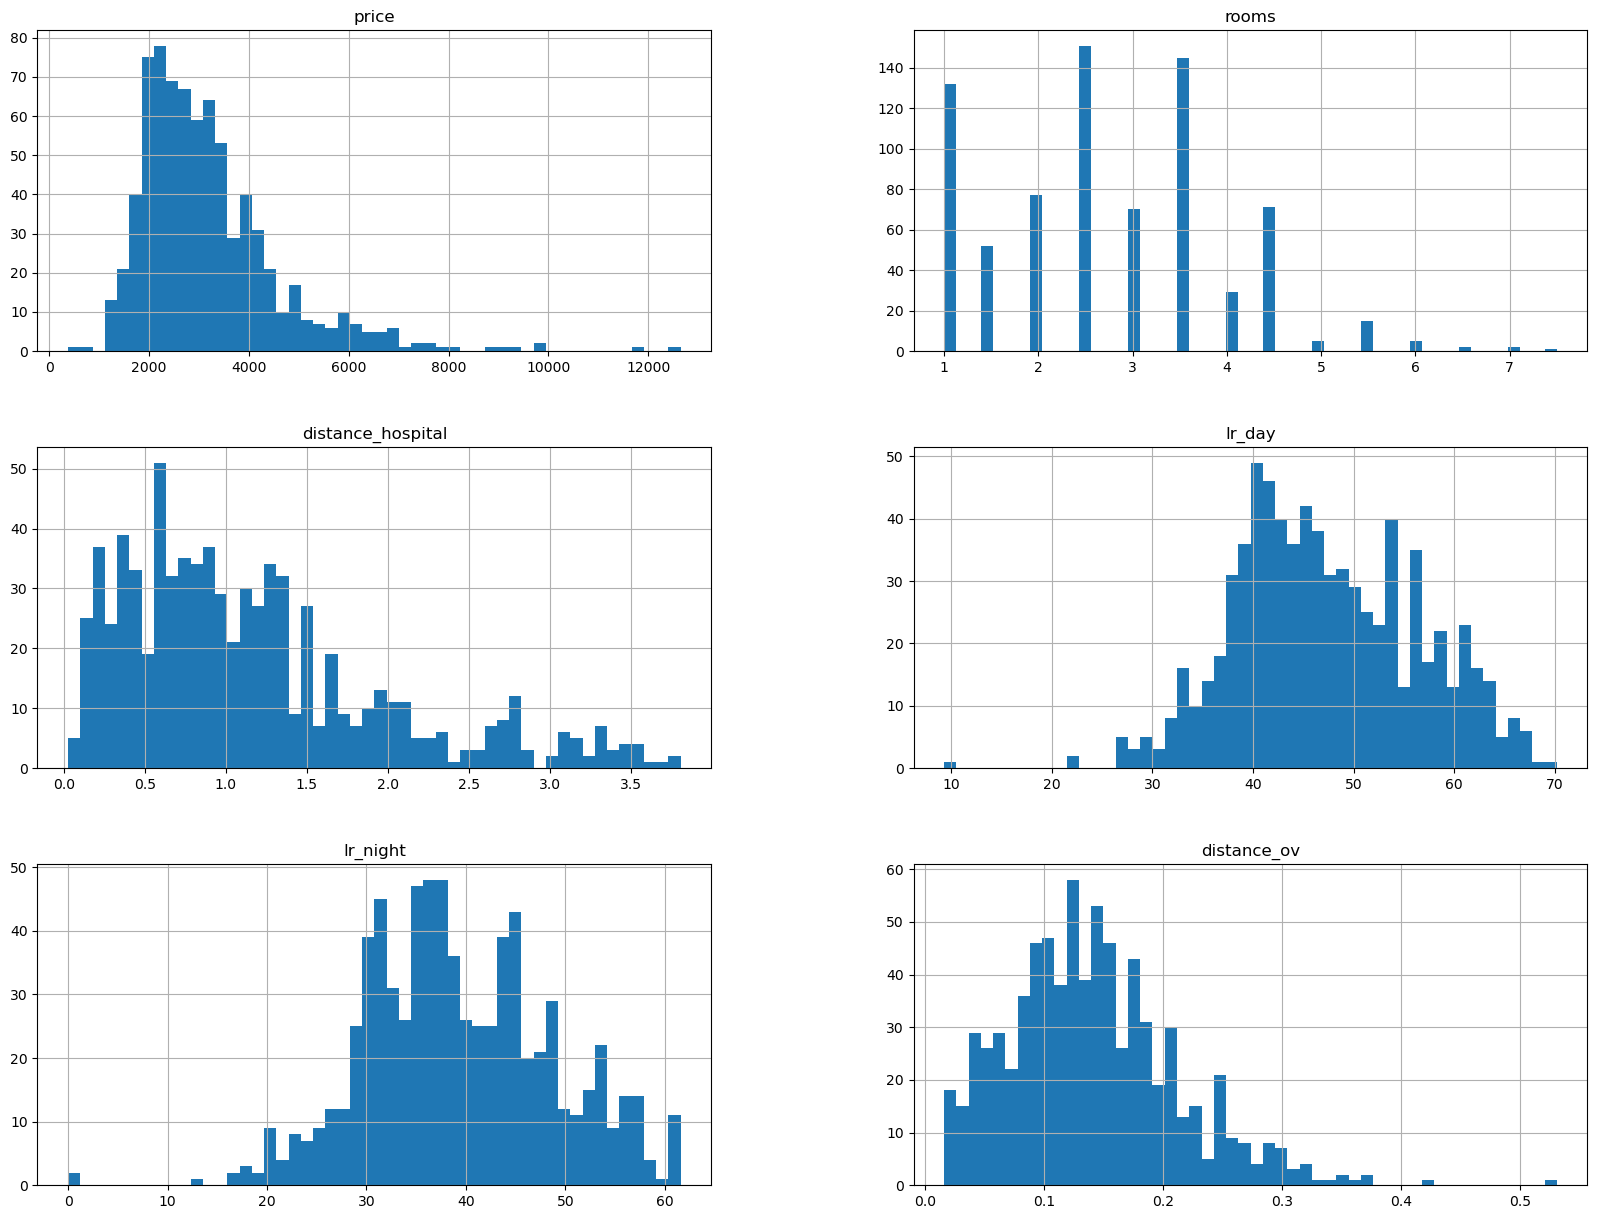

<Figure size 1200x800 with 0 Axes>

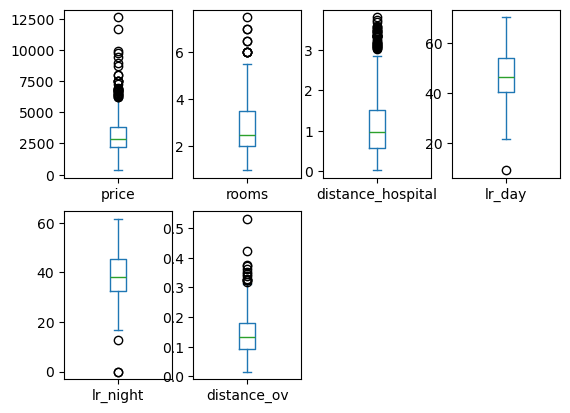

In [107]:
# Histograms for numerical attributes and boxplots

# Definition of Attributes to plot
df[['price', 'rooms', 'size', 'distance_hospital', 'lr_day', 'lr_night', 'distance_ov']].hist(bins=50, figsize=(20,15))
plt.show()

# Box plots for examining distributions and to spot outliers
num_attributes = ['price', 'rooms', 'size', 'distance_hospital', 'lr_day', 'lr_night', 'distance_ov']
plt.figure(figsize=(12, 8))
df[num_attributes].plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False)
plt.show()


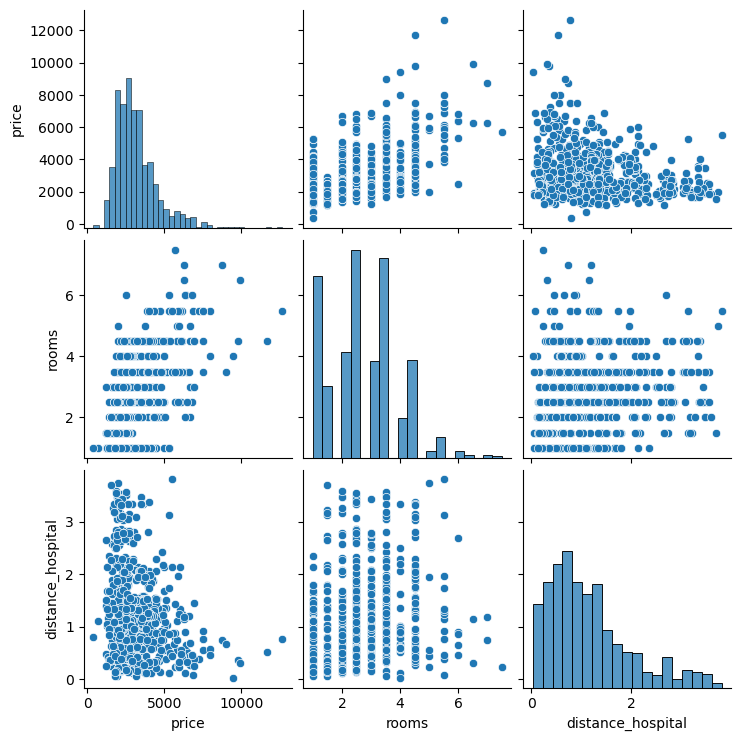

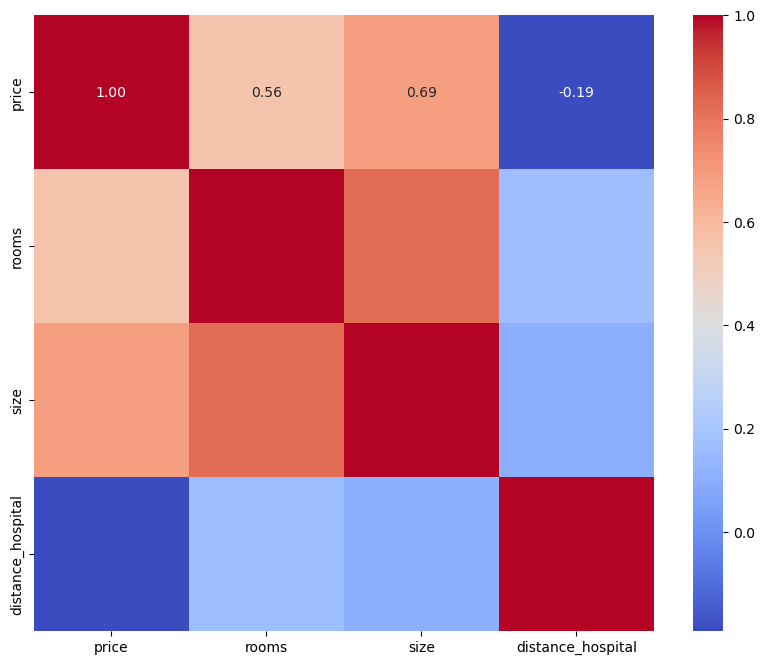

In [108]:
# Pair plot of selected variables
sns.pairplot(df[['price', 'rooms', 'size', 'distance_hospital']])
plt.show()

# Correlation matrix heatmap
corr_matrix = df[['price', 'rooms', 'size', 'distance_hospital']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

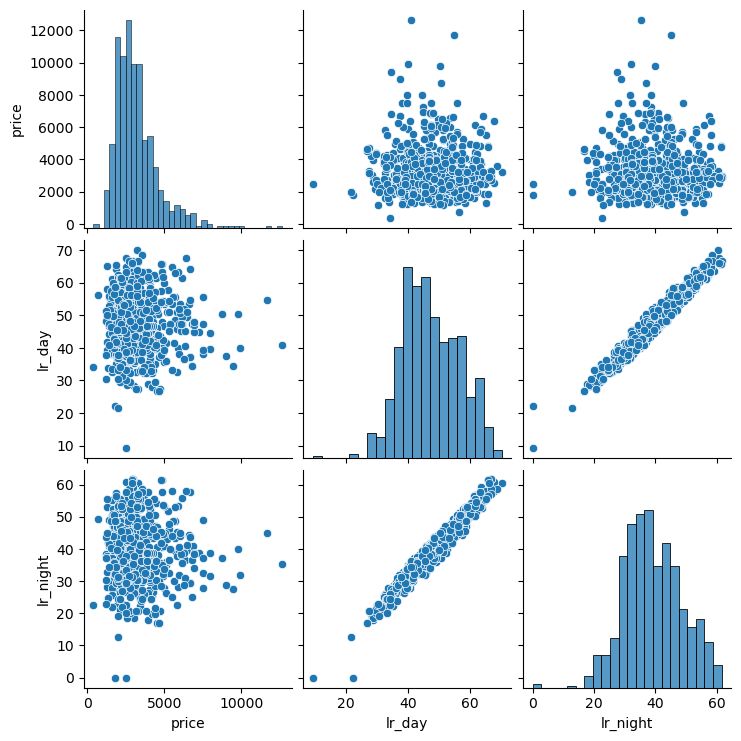

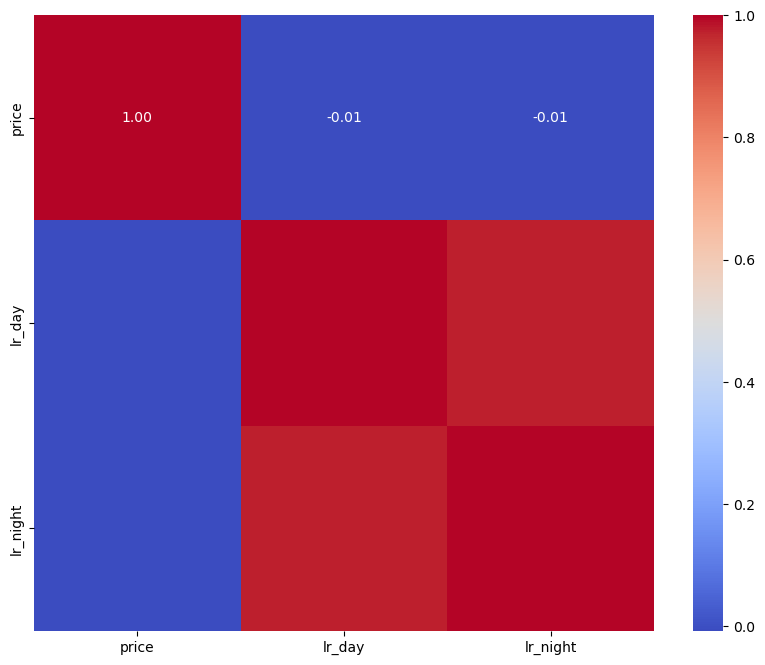

In [109]:
# Pair plot of selected variables
sns.pairplot(df[['price', 'lr_day', 'lr_night']])
plt.show()

# Correlation matrix heatmap
corr_matrix = df[['price', 'lr_day', 'lr_night']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [110]:
df.columns

Index(['price', 'address', 'description', 'rooms', 'size', 'latitude',
       'longitude', 'distance_hospital', 'lr_day', 'lr_night', 'distance_ov',
       'wbauj', 'modern', 'erstvermietung', 'zentral', 'see', 'neu', 'stöckig',
       'traum', 'bijou', 'neubau', 'balkon', 'charmant', 'erstbezug',
       'keine_description', '1 Zimmer', '1.5 Zimmer', '2 Zimmer', '2.5 Zimmer',
       '3 Zimmer', '3.5 Zimmer', '4 Zimmer', '4.5 Zimmer', '5 Zimmer',
       '5.5 Zimmer', '6 Zimmer', '6.5 Zimmer', '7 Zimmer', '7.5 Zimmer', 'y0',
       'y1999', 'y2000', 'y2001', 'y2003', 'y2004', 'y2005', 'y2006', 'y2007',
       'y2008', 'y2009', 'y2010', 'y2011', 'y2012', 'y2013', 'y2014', 'y2015',
       'y2016', 'y2017', 'y2018', 'y2019', 'y2020', 'y2021', 'y2022', 'y2023',
       'y2024'],
      dtype='object')

In [111]:
### violinplots test
df.to_clipboard()

In [112]:
# Save the DataFrame to a pickle file
df.to_pickle('final_dataframe.pkl')

## Geolocatoin Analysis <a name="loc"></a>

In [113]:


# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Set the coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Transform the GeoDataFrame to the coordinate system used by contextily (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)


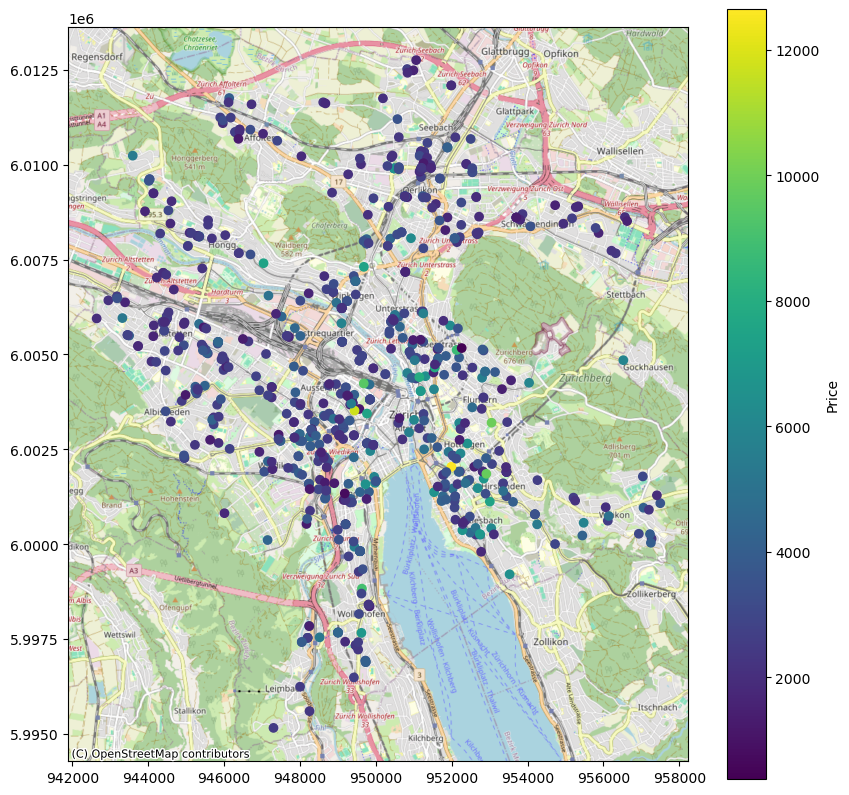

In [114]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column='price', legend=True, legend_kwds={'label': "Price"})

# Add basemap from contextily using a different source
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

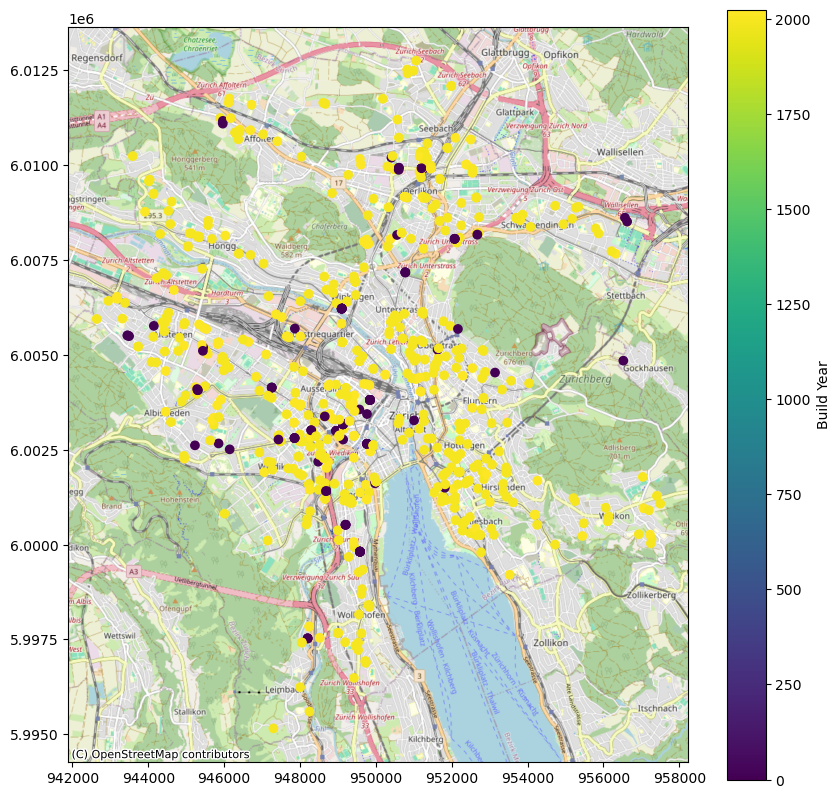

In [115]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column='wbauj', legend=True, legend_kwds={'label': "Build Year"})

# Add basemap from contextily using a different source
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Show plot
plt.show()

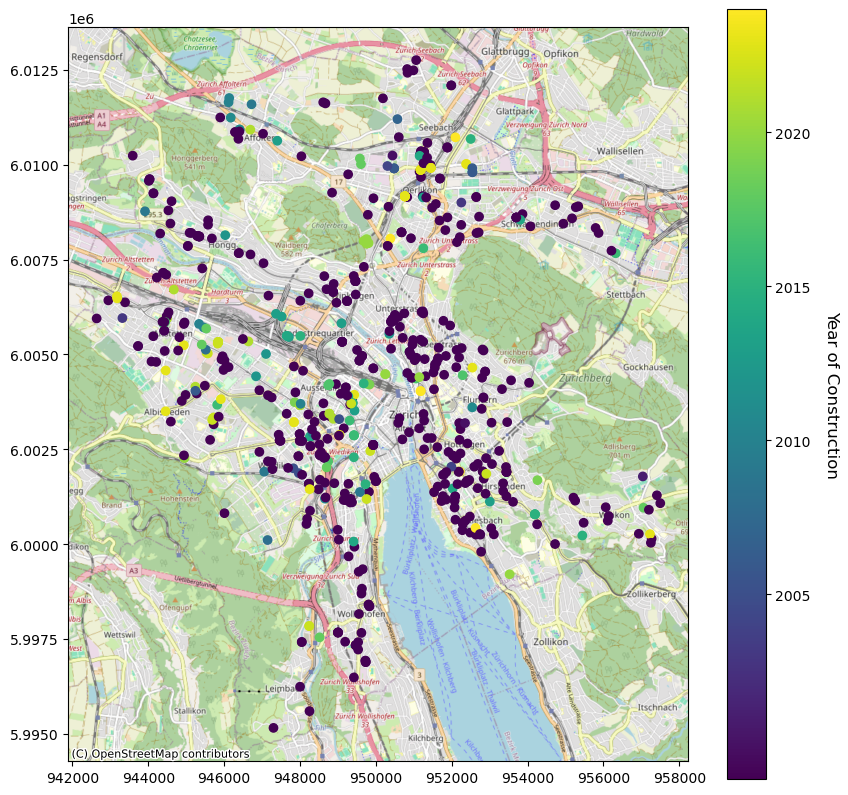

In [116]:
# Visualization without datasets that have no infomation about the bilding build year

# Filter out rows where 'wbauj' is 0
df2 = df[df['wbauj'] != 0]

# Convert DataFrame to GeoDataFrame
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude))



# Set the coordinate reference system to WGS84 (EPSG:4326)
gdf2.set_crs(epsg=4326, inplace=True)

# Transform the GeoDataFrame to the coordinate system used by contextily (EPSG:3857)
gdf2 = gdf2.to_crs(epsg=3857)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
plot = gdf2.plot(ax=ax, column='wbauj', legend=True, legend_kwds={'label': "Build Year", 'orientation': "vertical"})

# Customize colorbar
cbar = plot.get_figure().get_axes()[1]
cbar.set_ylabel('Year of Construction', rotation=270, labelpad=20, fontsize=12)
cbar.set_yticks([2005, 2010, 2015, 2020])  # Adjust ticks as needed
cbar.set_yticklabels(['2005', '2010', '2015', '2020'])  # Adjust labels as needed

# Add basemap from contextily using a different source
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Show plot
plt.show()